In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

In [2]:

from scipy.stats import rv_continuous
from scipy.interpolate import interp1d
from matplotlib.patches import Circle
from scipy.special import gamma
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy import exp, sqrt
from scipy.integrate import quad, dblquad, nquad
import matplotlib.patches as patches
from itertools import product
from scipy.integrate import quad
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.neighbors import KDTree
import sys
from py_unsio import *
import os
import wkbl
from wkbl.astro.halo_info import *
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import wkbl.astro.nbody_essentials as nbe
import cfalcon
CF =cfalcon.CFalcon()
import iminuit
from iminuit import Minuit, describe, Struct
from matplotlib.colors import LogNorm
from matplotlib.ticker import FormatStrFormatter


# Hydro

In [3]:
hydro = wkbl.astro.halo_info.AdicoraHydro()

In [5]:
hydro.path

'/data/OWN/Adicora/SF0/Stable/output_00041'

In [7]:
hydro = wkbl.astro.halo_info.AdicoraHydro()
simname=hydro.name
myhydro = wkbl.Galaxy_Hound(hydro.path)
print myhydro.dm.pos3d[:,0].max()
zoom_reg = np.where(myhydro.dm.mass==myhydro.dm.mass.min())
nucenter = nbe.real_center(myhydro.dm.pos3d[zoom_reg], myhydro.dm.mass[zoom_reg])
myhydro.center_shift(nucenter)#hydro.c_dm_com)
myhydro.r_virial(600,n=1)


loading Dark matter..
loading Stars..
loading Gas..
36837.883
| r_200 = 211.52
| Diagonal matrix computed 
|    | 19, 0, 0|
| D =| 0, 15, 0|
|    | 0,  0, 4|


In [8]:
print myhydro.gs.hsml.min()
print myhydro.dm.mass.min()
print myhydro.st.mass.min()

0.2810627
1536979.0
183658.06


In [9]:
pos_dm = np.array(myhydro.dm.pos3d.reshape(len(myhydro.dm.pos3d)*3),dtype=np.float32)
pos_gs = np.array(myhydro.gs.pos3d.reshape(len(myhydro.gs.pos3d)*3),dtype=np.float32)
pos_st = np.array(myhydro.st.pos3d.reshape(len(myhydro.st.pos3d)*3),dtype=np.float32)
pos = np.concatenate((pos_dm, pos_st, pos_gs))
phi_cord = np.concatenate((myhydro.dm.phi,myhydro.st.phi, myhydro.gs.phi))

mass = np.concatenate((myhydro.dm.mass,myhydro.st.mass,myhydro.gs.mass))
v = np.concatenate((myhydro.dm.v,myhydro.st.v,myhydro.gs.v))
print len(mass)*3, len(pos)
pos3d = pos.reshape(len(pos)/3,3)
r2 = pos3d[:,0]**2 + pos3d[:,1]**2 +pos3d[:,2]**2

5410869 5410869


# DMO

In [10]:
dmo = wkbl.astro.halo_info.Adicoradmo()
myDMO = wkbl.Galaxy_Hound(dmo.path)
myDMO.center_shift(dmo.c_dm_com)
myDMO.r_virial(600,n=20)


loading Dark matter..


In [11]:
print myDMO.r200
print myDMO.dm.mass.min()
print dmo.path

205.6640625
227993.1
/data/OWN/DMO/Adicora/output_00041


In [12]:
def eddingtong_from_file(path):
    files = np.loadtxt(path)
    return files[:,0], files[:,1]



In [13]:



def maxw(v,sigma,vesc):
    N = np.sqrt(32 * np.pi) * v**2 / sigma**3
    return N * (np.exp(- v**2 / 2. / sigma**2 )- np.exp(-vesc**2/2./sigma**2))

def maxw_check(v,sigma):
    N = np.sqrt(32 * np.pi) * v**2 / sigma**3
    return N * (np.exp(- v**2 / 2. / sigma**2 ))

get_maxw = np.vectorize(maxw)
get_maxwChec = np.vectorize(maxw_check)


def eddingtong_from_file(path):
    files = np.loadtxt(path)
    return files[:,0], files[:,1]

def fdv_plot_chi2_max_edd(ax, path, limmin, limmax,index=0,spherical=False, save=False,outname="/home/arturo/Pictures/ploto.png",width=None):
    # get eddington fdv from file
    v, fv = eddingtong_from_file(path)
    # interpolation of eddington points
    f = interp1d(v,fv)
    # get data points from simulations errors included
    # particles in the shell between limmin and limmax
    shell_wc = (myhydro.dm.r>limmin)&(myhydro.dm.r<limmax)
    if width == None:
        width = limmin /6.
    disc = (np.abs(myhydro.dm.pos3d[:,2])<width)
    local_v_wc = myhydro.dm.v[shell_wc]
    v_disc_in_the_shell = myhydro.dm.v[shell_wc&disc]
    Ntot=len(local_v_wc)
    # speed distribution in the shell
    bins = np.linspace(0,local_v_wc.max(),30)
    hist_wc, bins_wc = np.histogram(myhydro.dm.v[shell_wc],bins=bins,normed=True)
    x = (bins_wc[1:]+bins_wc[:-1])/2
    # considering informations from theory inside the bins
    fv_the = N = test = means= binsize = np.array([])
    for i in range(len(bins_wc)-1):
        pop = local_v_wc[(local_v_wc>bins_wc[i])&(local_v_wc<=bins_wc[i+1])]
        if len(pop)==0:
            continue
        try:            
            fv_the = np.append(fv_the, quad(f,bins_wc[i],bins_wc[i+1])[0] / (bins_wc[i+1] - bins_wc[i]))
            test = np.append(test,(bins_wc[i+1]+ bins_wc[i])/2)
            means, N = np.append(means,np.average(pop)), np.append(N,len(pop))
        except:
            test = np.append(test,(bins_wc[i+1]+ bins_wc[i])/2)
            fv_the = np.append(fv_the,0.0)
            pop = local_v_wc[(local_v_wc>bins_wc[i])&(local_v_wc<=bins_wc[i+1])]
            means, N = np.append(means,np.average(pop)), np.append(N,len(pop))
    dof = len(test)  
    # normalizations factor for data histogram
    ptot = np.sum(N)
    Ntot = np.trapz(np.nan_to_num(N),x=np.nan_to_num(means))

    ## MAXWELLIAN Fdv
    # circular velocity
    enclosed_m = (np.sum(mass[np.where(r2<limmin**2)])+ np.sum(mass[np.where(r2<limmax**2)]))/2.
    vc = np.sqrt(myhydro.p.G * enclosed_m / ((limmin + limmax) /2. )) * myhydro.p.kpctokm
    # for gas
    vc_gas = np.mean(myhydro.gs.vphi[(myhydro.gs.R>limmin)&(myhydro.gs.R<limmax)&(np.abs(myhydro.gs.pos3d[:,2])<2.)])
    std_vc_gas = np.std(myhydro.gs.vphi[(myhydro.gs.R>limmin)&(myhydro.gs.R<limmax)&(np.abs(myhydro.gs.pos3d[:,2])<2.)])
    vc_dm = np.nanmean(myhydro.dm.v[(myhydro.dm.R>limmin)&(myhydro.dm.R<limmax)&(np.abs(myhydro.dm.pos3d[:,2])<2.)])
    #for stars
    vc_stars = np.nanmean(myhydro.st.v[(myhydro.st.R>limmin)&(myhydro.st.R<limmax)&(np.abs(myhydro.st.pos3d[:,2])<2.)])
    std_vc_stars = np.nanstd(myhydro.st.v[(myhydro.st.r>limmin)&(myhydro.st.r<limmax)])    
    leno = len(myhydro.st.v[(myhydro.st.r<limmin)&(myhydro.st.r<limmax)])
    # v escape from potential
    if (spherical):
        v_esc , sig_vesc = hydro.v_esc_sph[index], hydro.v_esc_sigma_sph[index]
    else:
        v_esc , sig_vesc = hydro.v_esc_iso[index], hydro.v_esc_sigma_iso[index]
    # this sigma is a parameter in the fdv not an error of any kind
    sigma_8  = vc/ np.sqrt(2.)
    maxwellian = get_maxw(test,sigma_8,v_esc)
    # normalizarion factor
    N0 = np.trapz(maxwellian[test<v_esc], x=test[test<v_esc])
    maxwellian /= N0
    ############################
    max_check = get_maxwChec(test,sigma_8)
    # normalizarion factor
    N0_Check = np.trapz(max_check[test<v_esc], x=test[test<v_esc])
    max_check /= N0_Check
    ############################
    ## CHI2 s 
    #error in data
    sigma = np.sqrt(N)/Ntot
    # eddington
    chi2 = np.nansum((((N/Ntot) - fv_the)**2 / (sigma**2))[(fv_the>0)])
    # trucated maxwellian
    chi2_max_t = np.nansum((((N/Ntot) - maxwellian)**2 / (sigma**2))[(fv_the>0)])
    # maxwellian
    chi2_max = np.nansum((((N/Ntot) - max_check)**2 / (sigma**2))[(fv_the>0)])

    #for i in range(len(N)):
    #    print test[i],((((N/Ntot) - fv_the)**2 / (fv_the**2)))[i],((((N/Ntot) - maxwellian)**2 / (maxwellian**2)))[i]
    # v escape from potential
    if (spherical):
        v_esc , sig_vesc = hydro.v_esc_sph[index], hydro.v_esc_sigma_sph[index]
    else:
        v_esc , sig_vesc = hydro.v_esc_iso[index], hydro.v_esc_sigma_iso[index]
    # plotting
    maxi_v = (N/Ntot).max()
    ax.set_xlim([0,1.1*v_esc])
    ax.set_ylim([0,2.5*maxi_v])
    x=np.linspace(v[0],v[-2],100)
    ax.plot(x,f(x),'k-',lw=1.6,label=r"$\rm Eddington$")#,yerr=means/np.sqrt(N),xerr=sigma_x)
    ax.errorbar(test,N/Ntot,yerr=np.sqrt(N)/Ntot,xerr=((bins[1:]-bins[:-1])/2.)[:dof],c='g',lw=1.5,fmt=".", label="data")
    #ax.set_xlabel(r"$|\vec{v}|$ [km/s]",fontsize=16)
    ax.set_ylabel(r"$f(v) $ ",fontsize=22)
    ax.axvline(x=v_esc,color='k',linestyle='--')
    ax.axvspan(v_esc-sig_vesc, v_esc+sig_vesc, alpha=0.5, color='red',label=r"$v_{esc} \pm 1\sigma$ ")
    texto_max = r"$\rm Maxwellian$"+"\n"
    texto_max += r" $\chi^2_{red} = $"
    texto_max += r"${0:.2f}$".format(chi2_max/dof)
    texto_max_t = r"$\rm Trucated\,\, Maxwellian$"+"\n"
    texto_max_t += r"    $\chi^2_{red} = $"
    texto_max_t += r"${0:.2f}$".format(chi2_max_t/dof)
    texto_edd = r"$  \rm Eddington$"+"\n"
    texto_edd += r" $\chi^2_{red} = $"
    texto_edd += r"${0:.2f}$".format(chi2/dof)
    texto_vc = r"$v_c =$ "
    texto_vc += r"${0:.2f} \rm\,\, km/ s$".format(vc,leno)
    texto_vc += "\n"
    texto_vc += "$dof = {0}$".format(dof)
    t_color = "#850707"
    #fig.text(0.15,0.88,texto_max,fontsize=16,color='r')
    fig.text(0.15,0.85,texto_max_t,fontsize=16,color=t_color)
    fig.text(0.565,0.85,texto_max,fontsize=16,color='r')
    fig.text(0.4,0.85,texto_edd,fontsize=16,color='k')
    if (vc>=0):
        fig.text(0.15,0.75,texto_vc,fontsize=16,color='k')
    fig.text(0.7,0.70,r"$\rm Hydro$",fontsize=26,color='k')

    ax.set_title(str(limmin)+" kpc < r < "+str(limmax)+" kpc ", fontsize=18)
    max_v = np.linspace(0,1.5*test.max(),50)
    ax.plot(max_v,get_maxw(max_v,sigma_8,v_esc)/N0,c=t_color,ls='--',lw=1.6,label=r"$\rm Truncated \,\,Maxwellian$")
    ax.plot(max_v,get_maxwChec(max_v,sigma_8)/N0_Check,'r-',lw=1.,label=r"$\rm Maxwellian$")
    legend = ax.legend(loc='upper right', ncol=1, shadow=False, fontsize=14)
    frame = legend.get_frame()
    max_max, max_edd = (get_maxw(max_v,sigma_8,v_esc)/N0).max(),f(x).max()
    maxi_v = np.array([max_max, max_edd]).max()
    ax.set_ylim([0,1.6*maxi_v])
    if (save):
        plt.savefig(outname+".pdf",dpi=300)
        

def fdv_plot_chi2_max_eddDMO(ax, path, limmin, limmax,index=0, spherical=False, save=False,outname="/home/arturo/Pictures/ploto.png",width=None):
    # get eddington fdv from file
    v, fv = eddingtong_from_file(path)
    # interpolation of eddington points
    f = interp1d(v,fv)
    # get data points from simulations errors included
    # particles in the shell between limmin and limmax
    shell_wc = (myDMO.dm.r>limmin)&(myDMO.dm.r<limmax)
    if width == None:
        width = limmin /6.
    disc = (np.abs(myDMO.dm.pos3d[:,2])<width)
    local_v_wc = myDMO.dm.v[shell_wc]
    v_disc_in_the_shell = myDMO.dm.v[shell_wc&disc]
    Ntot=len(local_v_wc)
    # speed distribution in the shell
    bins = np.linspace(0,local_v_wc.max(),30)
    hist_wc, bins_wc = np.histogram(myDMO.dm.v[shell_wc],bins=bins,normed=True)
    x = (bins_wc[1:]+bins_wc[:-1])/2
    # considering informations from theory inside the bins
    fv_the = N = s = test = means = np.array([])
    for i in range(len(bins_wc)-1):
        try:
            fv_the = np.append(fv_the, quad(f,bins_wc[i],bins_wc[i+1])[0] / (bins_wc[i+1] - bins_wc[i]))
            test = np.append(test,(bins_wc[i+1]+ bins_wc[i])/2)
            pop = local_v_wc[(local_v_wc>bins_wc[i])&(local_v_wc<=bins_wc[i+1])]
            means, N, s= np.append(means,np.average(pop)), np.append(N,len(pop)), np.append(s,np.std(pop))
        except:
            test = np.append(test,(bins_wc[i+1]+ bins_wc[i])/2)
            fv_the = np.append(fv_the,0.0)
            pop = local_v_wc[(local_v_wc>bins_wc[i])&(local_v_wc<=bins_wc[i+1])]
            means, N, s= np.append(means,np.average(pop)), np.append(N,len(pop)), np.append(s,np.std(pop))

    dof = len(test) 
    # normalizations factor for data histogram
    ptot=np.sum(N)
    Ntot = np.trapz(N,x=means)
    # v escape from potential
    if (spherical):
        v_esc , sig_vesc = dmo.v_esc_sph[index], dmo.v_esc_sigma_sph[index]
    else:
        v_esc , sig_vesc = dmo.v_esc_iso[index], dmo.v_esc_sigma_iso[index]
    ## MAXWELLIAN Fdv
    # circular velocity
    enclosed_m = (np.sum(myDMO.dm.mass[np.where(myDMO.dm.r<limmin)])+ np.sum(myDMO.dm.mass[np.where(myDMO.dm.r<limmax)]))/2.
    vc = np.sqrt(myDMO.p.G * enclosed_m / ((limmin + limmax) /2. )) * myDMO.p.kpctokm
    # this sigma is a parameter in the fdv not an error of any kind
    sigma_8  = vc / np.sqrt(2.)
    maxwellian = get_maxw(test,sigma_8,v_esc)
    # normalizarion factor
    N0 = np.trapz(maxwellian, x=test)
    maxwellian /= N0
    ############################
    max_check = get_maxwChec(test,sigma_8)
    # normalizarion factor
    N0_Check = np.trapz(max_check, x=test)
    max_check /= N0_Check
    ############################
    ## CHI2 s 
    #error in data
    sigma = np.sqrt(N)/Ntot
    # eddington
    chi2 = np.sum((((N/Ntot) - fv_the)**2 / (sigma)**2)[:-1])
    # truncated maxwellian
    chi2_max_t = np.sum((((N/Ntot) - maxwellian)**2 / (sigma**2))[:-1])
    # maxwellian
    chi2_max = np.sum((((N/Ntot) - max_check)**2 / (sigma**2))[:-1])
    
    # plotting
    #ax.set_xlim([0,1.2*v_esc])
    color_t = "#a21c1c"
    x=np.linspace(v[0],v[-2],100)
    ax.plot(x,f(x),'k-',lw=2,label=r"$\rm Eddington$")#,yerr=means/np.sqrt(N),xerr=sigma_x)
    ax.errorbar(test,N/Ntot,yerr=np.sqrt(N)/Ntot,xerr=((bins[1:]-bins[:-1])/2.)[:dof],c='#2a0972',lw=1.5,fmt=".", label="data")
    ax.set_xlabel(r"$v$ [km/s]",fontsize=22)
    ax.set_ylabel(r"$f(v) $ ",fontsize=22)
    ax.axvline(x=v_esc,color='k',linestyle='--')
    ax.axvspan(v_esc-sig_vesc, v_esc+sig_vesc, alpha=0.5, color='#721c09',label=r"$v_{esc} \pm 1\sigma$ ")
    texto_max = r"$\rm  Maxwellian$"+"\n"
    texto_max += r" $\chi^2_{red} = $"
    texto_max += r"${0:.2f}$".format(chi2_max/dof)
    texto_max_t = r"$\rm Truncated\,\,Maxwellian$"+"\n"
    texto_max_t += r"    $\chi^2_{red} = $"
    texto_max_t += r"${0:.2f}$".format(chi2_max_t/dof)
    texto_edd = r"$  \rm Eddington$"+"\n"
    texto_edd += r" $\chi^2_{red} = $"
    texto_vc = r"$v_c =$ "
    texto_vc += r"${0:.2f} \rm\,\, km/ s$".format(vc)
    texto_edd += r"${0:.2f}$".format(chi2/dof)
    fig.text(0.15,0.45,texto_max_t,fontsize=16,color=color_t)
    fig.text(0.565,0.45,texto_max,fontsize=16,color='#721c09')
    fig.text(0.4,0.45,texto_edd,fontsize=16,color='k')
    fig.text(0.7,0.25,r"$\rm DMO$",fontsize=26,color='k')
    if vc>136:
        fig.text(0.15,0.4,r"$dof = {0}$".format(dof),fontsize=16,color='k')
        fig.text(0.14,0.36,texto_vc,fontsize=16,color='k')
    else:
        fig.text(0.4,0.4,r"$dof = {0}$".format(dof),fontsize=16,color='k')
        fig.text(0.38,0.36,texto_vc,fontsize=16,color='k')


    #ax.set_title(str(limmin)+" kpc < r < "+str(limmax)+" kpc ", fontsize=18)
    max_v = np.linspace(0,1.5*test.max(),100)
    ax.plot(max_v,get_maxwChec(max_v,sigma_8)/N0_Check,lw=1.6,c=color_t,label=r"$\rm Maxwellian$")
    ax.plot(max_v,get_maxw(max_v,sigma_8,v_esc)/N0,c='#721c09',ls="--",lw=1.6,label=r"$\rm Truncated\,\,Maxwellian$")

    legend = ax.legend(loc='upper right', ncol=1, shadow=False, fontsize=14)
    frame = legend.get_frame()
    max_max, max_edd = (get_maxw(max_v,sigma_8,v_esc)/N0).max(),f(x).max()
    maxi_v = np.array([max_max, max_edd]).max()
    ax.set_ylim([0,1.4*maxi_v])
    if (save):
        plt.savefig(outname+".pdf",dpi=300)

<IPython.core.display.Javascript object>


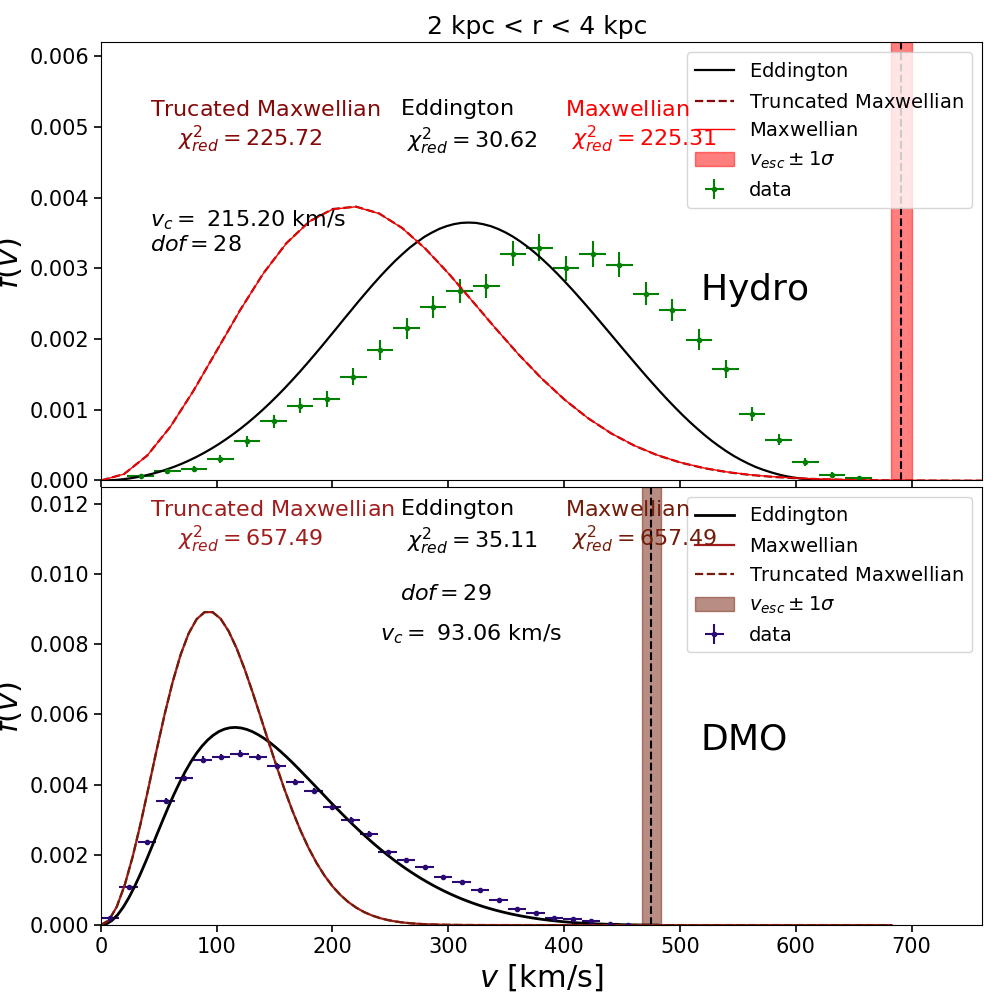

In [14]:
fig, ax = plt.subplots(2,1,sharex=True,figsize=[10,10])
path = "/home/arturo/Documents/LAM/LAM2LUPM/Adicora/fdvs/fv_Eddington_Adicora_DM_baryons_Rmax=1453.96kpc_3kpc_no_divergence.txt"
fdv_plot_chi2_max_edd(ax[0],path,2,4,index=0)
path = "/home/arturo/Documents/LAM/LAM2LUPM/Adicora/fdvs/fv_Eddington_Adicora_DMO_Rmax=1418.67kpc_3kpc_no_divergence.txt"
fdv_plot_chi2_max_eddDMO(ax[1],path,2,4,index=0)
fig.tight_layout(h_pad=-0.4)
ax[0].tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax[0].tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
ax[1].tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax[1].tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
plt.savefig("/home/arturo/Documents/LAM/LAM2LUPM/"+hydro.namenospace+"/vdf_comparison_"+hydro.namenospace+"_3kpc.pdf")

<IPython.core.display.Javascript object>


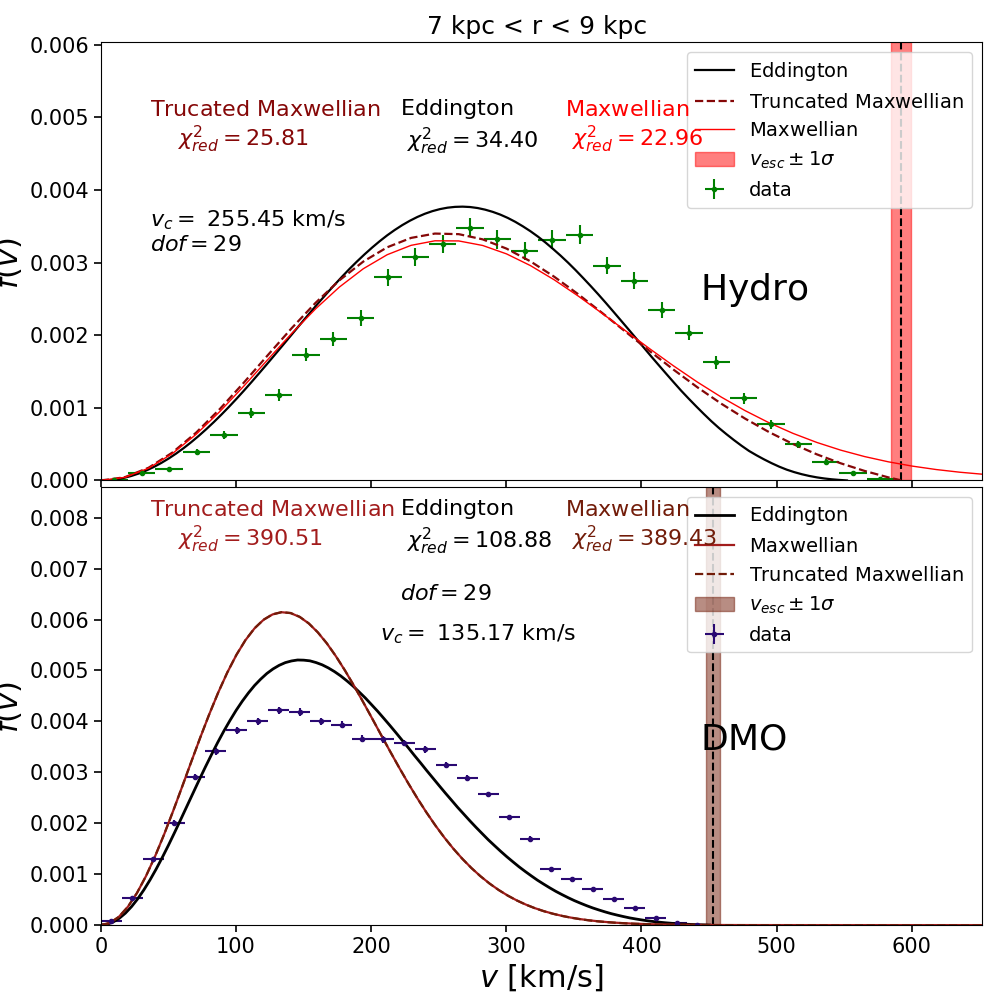

In [15]:
fig, ax = plt.subplots(2,1,sharex=True,figsize=[10,10])
path = "/home/arturo/Documents/LAM/LAM2LUPM/Adicora/fdvs/fv_Eddington_Adicora_DM_baryons_Rmax=1453.96kpc_8kpc_no_divergence.txt"
fdv_plot_chi2_max_edd(ax[0],path,7,9,index=1)
path = "/home/arturo/Documents/LAM/LAM2LUPM/Adicora/fdvs/fv_Eddington_Adicora_DMO_Rmax=1418.67kpc_8kpc_no_divergence.txt"
fdv_plot_chi2_max_eddDMO(ax[1],path,7,9,index=1)
fig.tight_layout(h_pad=-0.4)
ax[0].tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax[0].tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
ax[1].tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax[1].tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
plt.savefig("/home/arturo/Documents/LAM/LAM2LUPM/"+hydro.namenospace+"/vdf_comparison_"+hydro.namenospace+"_8kpc.pdf")

<IPython.core.display.Javascript object>


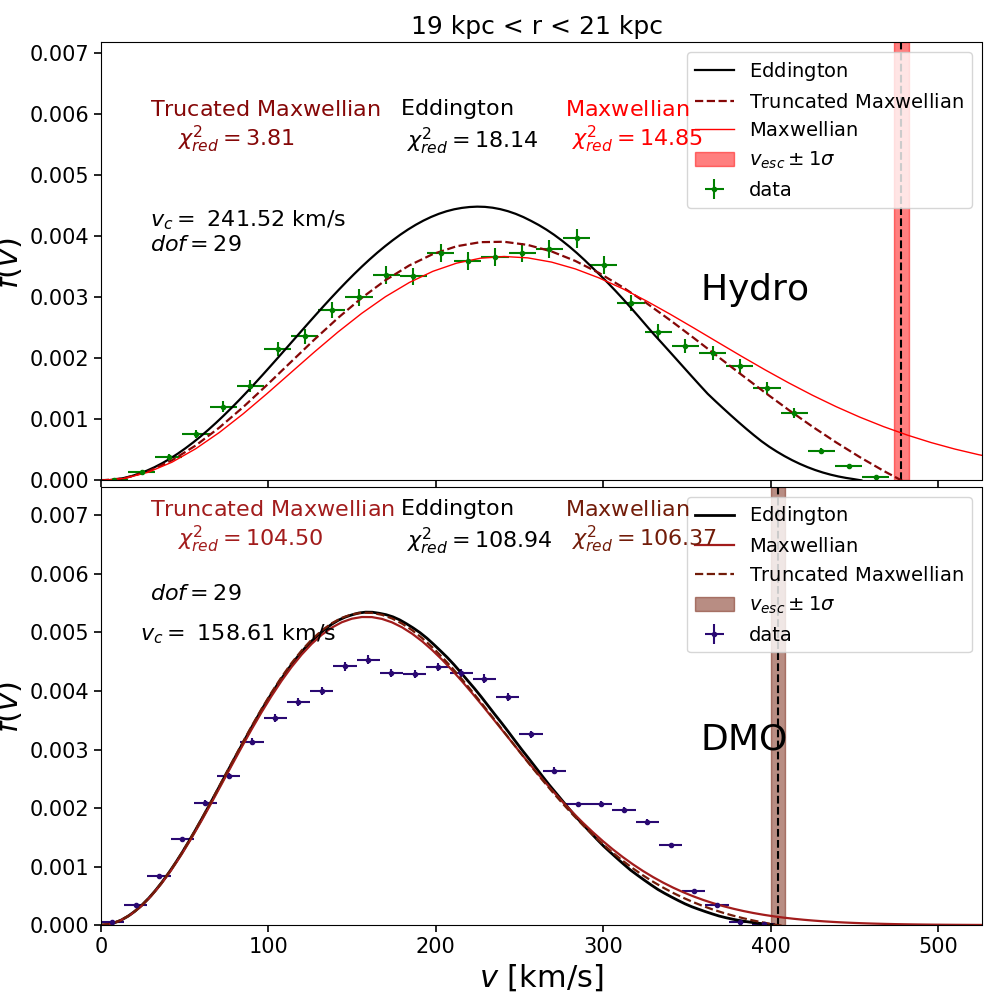

In [16]:
fig, ax = plt.subplots(2,1,sharex=True,figsize=[10,10])
path = "/home/arturo/Documents/LAM/LAM2LUPM/Adicora/fdvs/fv_Eddington_Adicora_DM_baryons_Rmax=1453.96kpc_20kpc_no_divergence.txt"
fdv_plot_chi2_max_edd(ax[0],path,19,21,index=2)
path = "/home/arturo/Documents/LAM/LAM2LUPM/Adicora/fdvs/fv_Eddington_Adicora_DMO_Rmax=1418.67kpc_20kpc_no_divergence.txt"
fdv_plot_chi2_max_eddDMO(ax[1],path,19,21,index=2)
fig.tight_layout(h_pad=-0.4)
ax[0].tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax[0].tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
ax[1].tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax[1].tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
plt.savefig("/home/arturo/Documents/LAM/LAM2LUPM/"+hydro.namenospace+"/vdf_comparison_"+hydro.namenospace+"_20kpc.pdf")

<IPython.core.display.Javascript object>


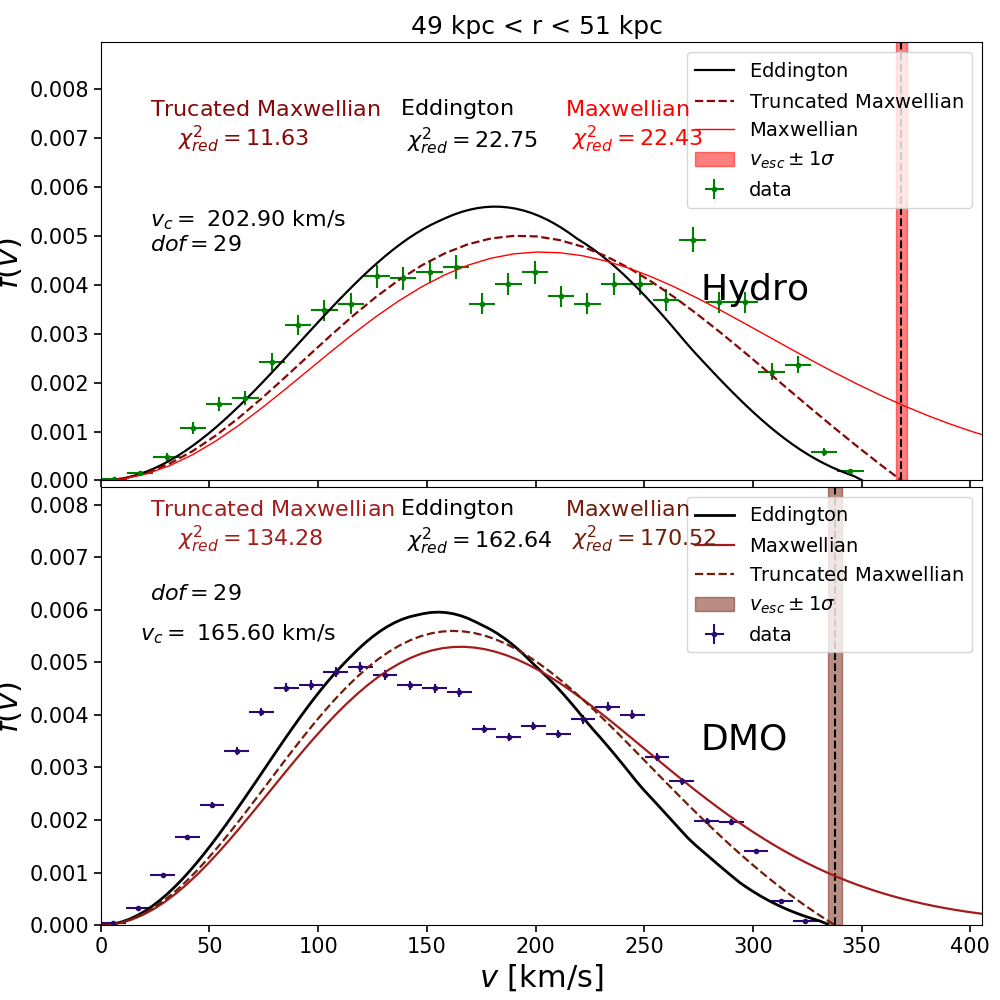

In [17]:
fig, ax = plt.subplots(2,1,sharex=True,figsize=[10,10])
path = "/home/arturo/Documents/LAM/LAM2LUPM/Adicora/fdvs/fv_Eddington_Adicora_DM_baryons_Rmax=1453.96kpc_50kpc_no_divergence.txt"
fdv_plot_chi2_max_edd(ax[0],path,49,51,index=3)
path = "/home/arturo/Documents/LAM/LAM2LUPM/Adicora/fdvs/fv_Eddington_Adicora_DMO_Rmax=1418.67kpc_50kpc_no_divergence.txt"
fdv_plot_chi2_max_eddDMO(ax[1],path,49,51,index=3)
fig.tight_layout(h_pad=-0.4)
ax[0].tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax[0].tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
ax[1].tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax[1].tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
plt.savefig("/home/arturo/Documents/LAM/LAM2LUPM/"+hydro.namenospace+"/vdf_comparison_"+hydro.namenospace+"_50kpc.pdf")

<IPython.core.display.Javascript object>


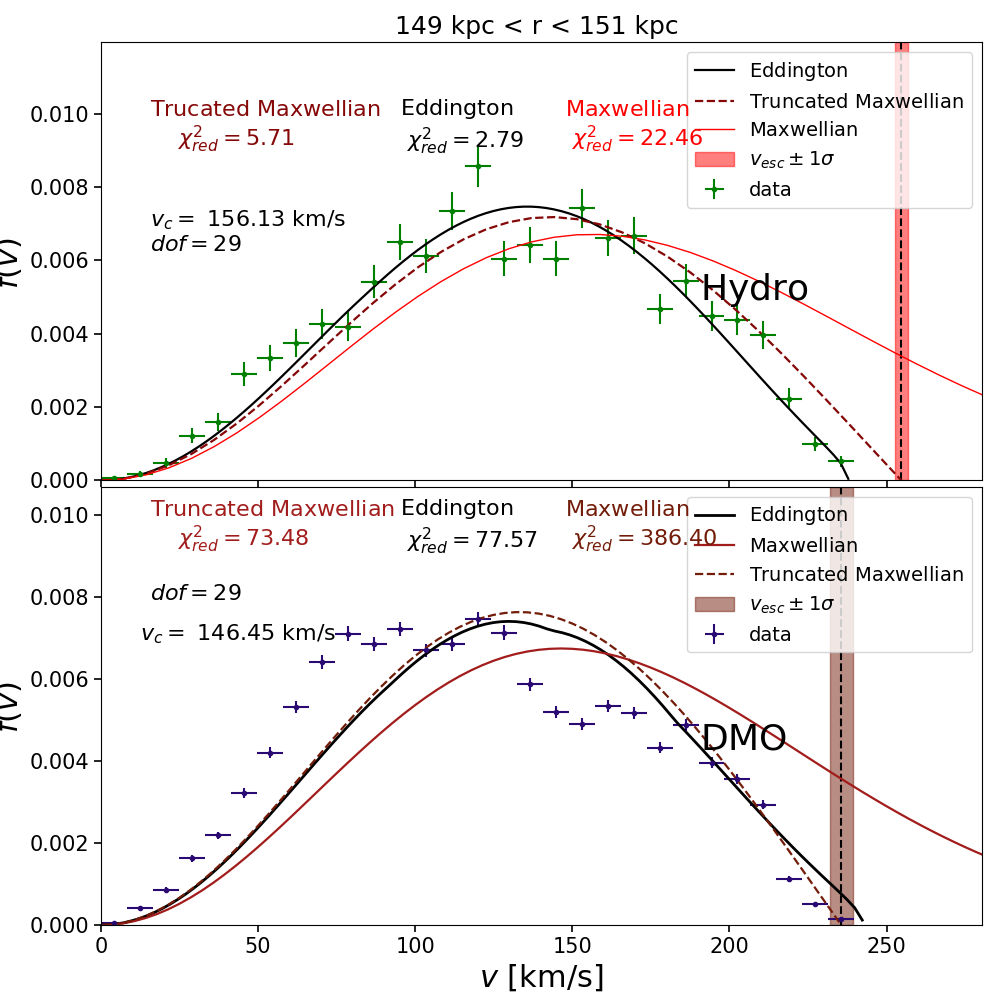

In [18]:
fig, ax = plt.subplots(2,1,sharex=True,figsize=[10,10])
path = "/home/arturo/Documents/LAM/LAM2LUPM/Adicora/fdvs/fv_Eddington_Adicora_DM_baryons_Rmax=1453.96kpc_150kpc_no_divergence.txt"
fdv_plot_chi2_max_edd(ax[0],path,149,151,index=4)
path = "/home/arturo/Documents/LAM/LAM2LUPM/Adicora/fdvs/fv_Eddington_Adicora_DMO_Rmax=1418.67kpc_150kpc_no_divergence.txt"
fdv_plot_chi2_max_eddDMO(ax[1],path,149,151,index=4)
fig.tight_layout(h_pad=-0.4)
ax[0].tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax[0].tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
ax[1].tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax[1].tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
plt.savefig("/home/arturo/Documents/LAM/LAM2LUPM/"+hydro.namenospace+"/vdf_comparison_"+hydro.namenospace+"_150kpc.pdf")

In [21]:
ok,myhydro.dm.rho,_= CF.getDensity(np.array(myhydro.dm.pos3d.reshape(len(myhydro.dm.pos3d)*3),dtype=np.float32), myhydro.dm.mass)
Pcrit = myhydro.dm._p.rho_crit
Mdm = myhydro.dm.mass.min()
myradiuses = myhydro.dm.r[np.argsort(myhydro.dm.r)]
tabN = np.cumsum(np.ones(len(myradiuses)))[1:]
myradiuses = myradiuses[1:]
Rp03 = np.sqrt(200/64.) * np.sqrt(4 * np.pi * Pcrit * tabN / 3. / Mdm ) * (myradiuses**1.5)/ np.log(tabN) 
val =0.6
R_P03 = myradiuses[ np.where(Rp03 > val) ][0]
print R_P03
hsml=  myhydro.gs.hsml.min()

# R array logarithmic Bining
r_p = np.logspace(np.log10(0.2*hsml),np.log10(hsml),15)
# histogram of dm particles per logarithmic bin
n_hydro,r = np.histogram(myhydro.dm.r,bins=r_p)
# edges of bins
r1,r2 =r[:-1],r[1:]
# shell's volume
vol = 4.* np.pi * ((r2**3)-(r1**3)) / 3.
# density per shell
profilehydro_in = n_hydro*myhydro.dm.mass.min()/vol
# center of bins
r_in = (r_p[:-1]+r_p[1:])/2.



# R array logarithmic Bining
r_p = np.logspace(np.log10(2*hsml),np.log10(2.5*myhydro.r200),60)
# histogram of dm particles per logarithmic bin
n_hydro,r = np.histogram(myhydro.dm.r,bins=r_p)
# edges of bins
r1,r2 =r[:-1],r[1:]
# shell's volume
vol = 4.* np.pi * ((r2**3)-(r1**3)) / 3.
# density per shell
profilehydro = n_hydro*myhydro.dm.mass.min()/vol
# center of bins
r = (r_p[:-1]+r_p[1:])/2.
bin_size= (r_p[:-1]-r_p[1:])/2.
rr = r
# extra estatistics from Cfalcon density
mean_hydro = std_hydro = stdlog_hydro = n_hydro=np.array([])
for i in range(len(r_p)-1):
    shell_hydro = np.where((myhydro.dm.r > r_p[i])&(myhydro.dm.r < r_p[i+1])&(myhydro.dm.r > hsml))
    n_hydro = np.append(n_hydro,len(shell_hydro[0]))
    mean_hydro = np.append(mean_hydro,np.mean(myhydro.dm.rho[shell_hydro]))
    std_hydro = np.append(std_hydro,np.std(myhydro.dm.rho[shell_hydro]))
    stdlog_hydro = np.append(stdlog_hydro,np.std(np.log10(myhydro.dm.rho[shell_hydro])))

m_obs_hydro = n_hydro*myhydro.dm.mass.min()
n_hydro = np.array([len(myhydro.dm.mass[myhydro.dm.r<i]) for i in r]) 



2.338358421862859


<IPython.core.display.Javascript object>


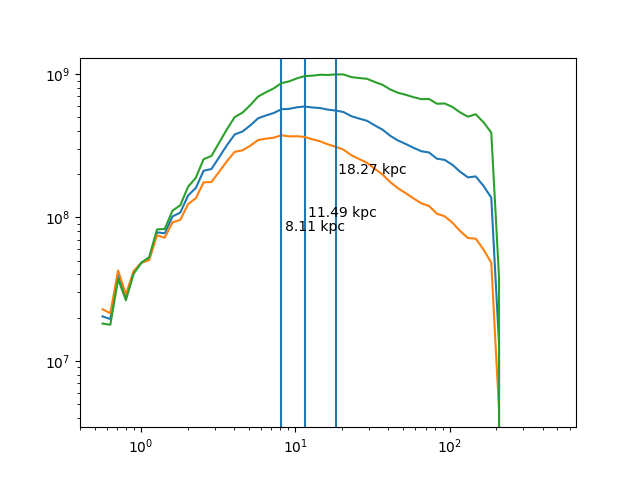

Text(18.7711,2e+08,'18.27 kpc')

In [26]:
fig,ax = plt.subplots()
ax.set_xscale("log")
ax.set_yscale("log")
pw=2
ax.plot(r_p[:-1],profilehydro*r_p[:-1]**pw,lw=1.5)
elmax = (r_p[:-1])[np.where((profilehydro*r_p[:-1]**pw)==(profilehydro*r_p[:-1]**pw).max())]
ax.axvline(x=elmax)
ax.text(elmax+0.5,1e8,"{0:.2f} kpc".format(elmax[0]))
pw=1.8
ax.plot(r_p[:-1],profilehydro*r_p[:-1]**pw,lw=1.5)
elmax = (r_p[:-1])[np.where((profilehydro*r_p[:-1]**pw)==(profilehydro*r_p[:-1]**pw).max())]
ax.axvline(x=elmax)
ax.text(elmax+0.5,8e7,"{0:.2f} kpc".format(elmax[0]))
pw=2.2
ax.plot(r_p[:-1],profilehydro*r_p[:-1]**pw,lw=1.5)
elmax = (r_p[:-1])[np.where((profilehydro*r_p[:-1]**pw)==(profilehydro*r_p[:-1]**pw).max())]
ax.axvline(x=elmax)
ax.text(elmax+0.5,2e8,"{0:.2f} kpc".format(elmax[0]))


